In [1]:
!pip install pydotplus
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score,RepeatedStratifiedKFold,GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint
from six import StringIO 
from IPython.display import Image
import graphviz
import pydotplus
from numpy import mean
from numpy import std
from xgboost import XGBClassifier

data = pd.read_csv("/kaggle/input/airline/airline.csv")
data = data.sample(n=20000, random_state=42) 
data = data.dropna(axis=0).reset_index(drop = True)
data.head(3)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=55f07537c3f8d4b61271fd6f8d0d19d42a9152bd28fe541b8dbb4bdd5cbf88c7
  Stored in directory: /root/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus


,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,59,Business travel,Business,1470,4,4,4,4,...,4,4,4,4,4,5,4,3,7,0.0
1,dissatisfied,disloyal Customer,22,Business travel,Eco,1771,1,1,1,4,...,5,4,3,4,3,1,4,4,0,0.0
2,satisfied,Loyal Customer,55,Business travel,Business,3657,0,5,0,2,...,4,4,4,4,4,3,4,3,12,8.0


Decision Tree
Accuracy: 0.914076
Precision: 0.921498
Recall: 0.923170
F1 Score: 0.922333


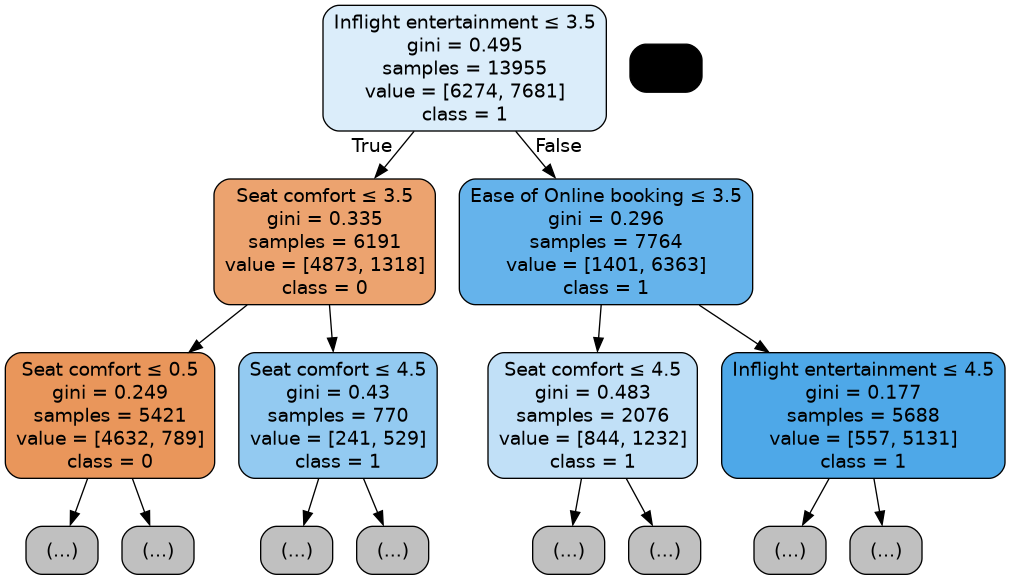

In [2]:

data['Class'] = data['Class'].map({"Business": 3, "Eco Plus": 2, "Eco": 1})
data['satisfaction'] = data['satisfaction'].map({"satisfied": 1, "dissatisfied": 0})
data = pd.get_dummies(data, drop_first = True)
y = data["satisfaction"]

X = data.copy()
X = X.drop("satisfaction", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)

csc = DecisionTreeClassifier()

csc = csc.fit(X_train,y_train)

y_pred = csc.predict(X_test)

print("Decision Tree")
dt_acc= metrics.accuracy_score(y_test, y_pred)
dt_prec= metrics.precision_score(y_test, y_pred)
dt_rec= metrics.recall_score(y_test, y_pred)
dt_f1= metrics.f1_score(y_test, y_pred)

print("Accuracy:", "%.6f" % dt_acc)
print("Precision:", "%.6f" % dt_prec)
print("Recall:", "%.6f" % dt_rec)
print("F1 Score:", "%.6f" % dt_f1)

dot_data = StringIO()

export_graphviz(csc,out_file=dot_data,
               filled=True, rounded=True,max_depth = 2,
                special_characters=True, feature_names = X_train.columns, 
               class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('airline.png')
Image(graph.create_png())


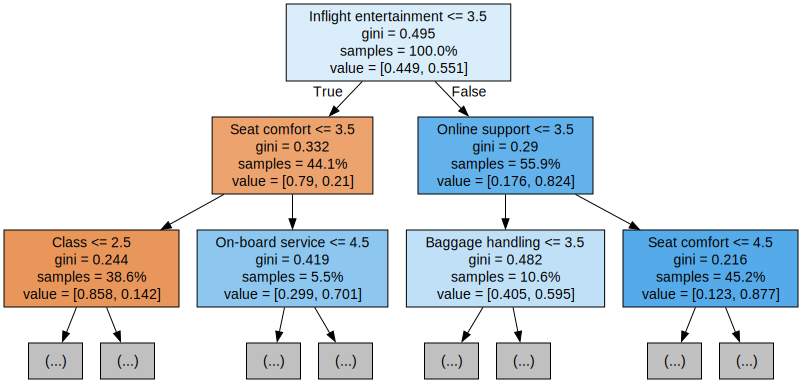

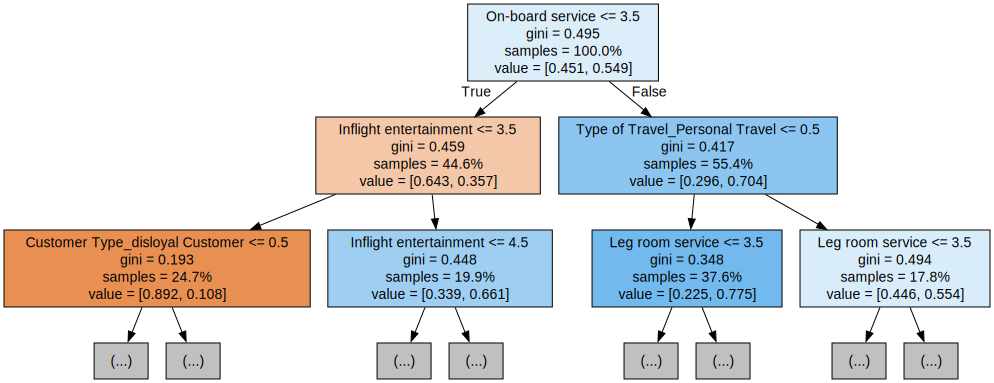

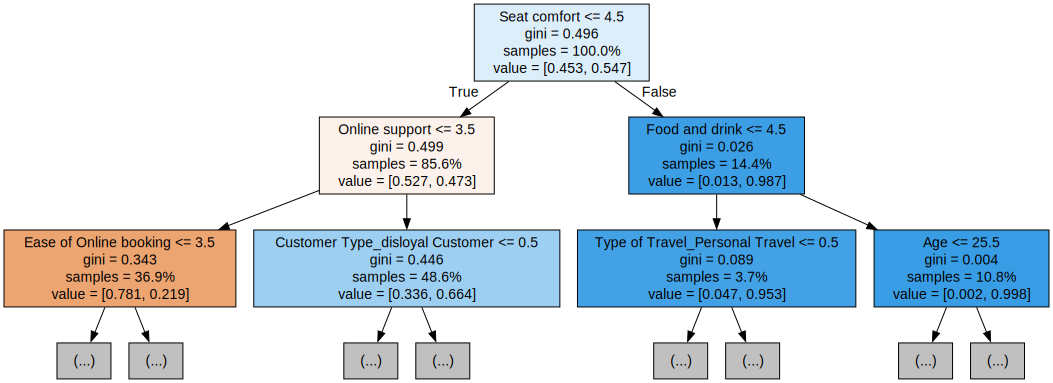

In [3]:

csrf = RandomForestClassifier()
csrf = csrf.fit(X_train, y_train)
y_pred = csrf.predict(X_test)

randomforest_accuracy = metrics.accuracy_score(y_test,y_pred)
randomforest_precision = metrics.precision_score(y_test,y_pred)
randomforest_recall = metrics.recall_score(y_test,y_pred)
randomforest_f1 = metrics.f1_score(y_test,y_pred)


for i in range(3):
    tree = csrf.estimators_[i]
    dot_data = export_graphviz(tree,
                              feature_names=X_train.columns,
                              filled=True,
                              max_depth=2,
                              proportion=True)
    graph= graphviz.Source(dot_data)
    display(graph)

In [4]:
param_dist = {'n_estimators':randint(50,500),
             'max_depth':randint(1,2)}


rf= RandomForestClassifier()

rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

print('Best hyperparameters: ', rand_search.best_params_)




Best hyperparameters:  {'max_depth': 1, 'n_estimators': 254}


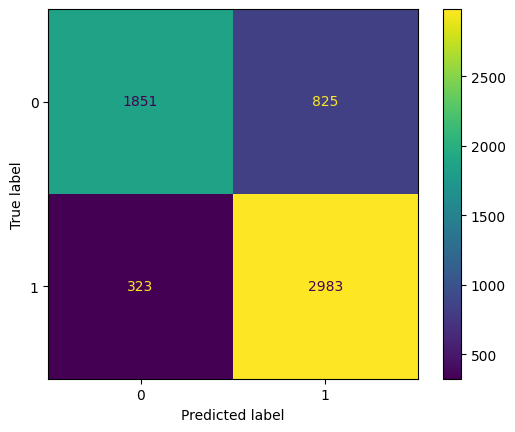

In [5]:
y_pred = best_rf.predict(X_test)

cm = metrics.confusion_matrix(y_test,y_pred)

metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [6]:

bestparam_accuracy = metrics.accuracy_score(y_test,y_pred)
bestparam_precision = metrics.precision_score(y_test,y_pred)
bestparam_recall = metrics.recall_score(y_test,y_pred)
bestparam_f1 = metrics.f1_score(y_test,y_pred)
print("Best Parameter Random Forest:")
print("Accuracy: ", bestparam_accuracy)
print("Precision: ", bestparam_precision)
print("Recall: ", bestparam_recall)
print("F1: ", bestparam_f1)

Best Parameter Random Forest:
Accuracy:  0.808090939485122
Precision:  0.7833508403361344
Recall:  0.9022988505747126
F1:  0.8386280573517009


<Axes: >

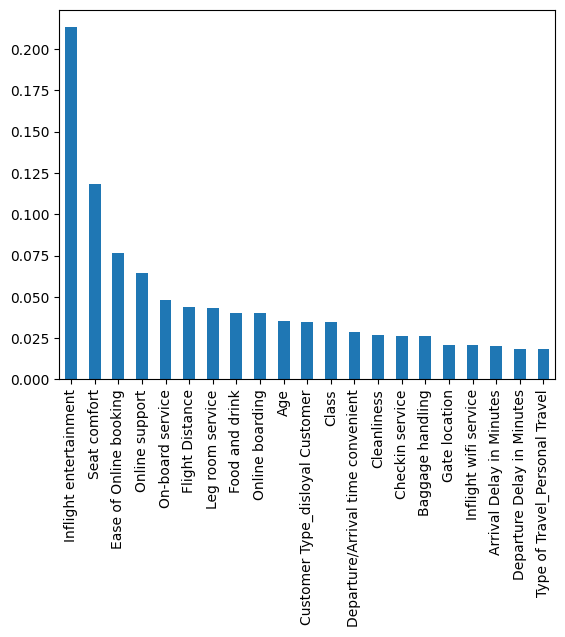

In [7]:
feature_importances = pd.Series(csrf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importances.plot.bar()

In [8]:
model = GradientBoostingClassifier()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)

n_scores = cross_val_score(model,X,y,scoring='accuracy',cv = cv, n_jobs=-1)

print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores),std(n_scores)))

print("Gradient Boosting Model")
gradient_accuracy = metrics.accuracy_score(y_test, y_pred)
gradient_precision = metrics.precision_score(y_test, y_pred)
gradient_recall = metrics.recall_score(y_test, y_pred)
gradient_f1 = metrics.f1_score(y_test, y_pred)


print("Accuracy:", "%.6f" % gradient_accuracy)
print("Precision:", "%.6f" % gradient_precision)
print("Recall:", "%.6f" % gradient_recall)
print("F1 Score:", "%.6f" % gradient_f1)



Mean Accuracy: 0.921 (0.006)
Gradient Boosting Model
Accuracy: 0.924273
Precision: 0.933982
Recall: 0.928615
F1 Score: 0.931291


In [9]:
xgb = XGBClassifier()

cv_params = {'max_depth': [3,4],
              'n_estimators': [5,10,15]
              }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'f1'
                     )

xgb_cv = xgb_cv.fit(X_train, y_train)
y_pred = xgb_cv.predict(X_test)
ac_score = metrics.accuracy_score(y_test, y_pred)
pc_score = metrics.precision_score(y_test, y_pred)
rc_score = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)



print('accuracy score:', ac_score)


print('precision score:', pc_score)


print('recall score:', rc_score)


print('f1 score:', f1_score)

accuracy score: 0.9172517552657974
precision score: 0.9255222524977293
recall score: 0.9246823956442831
f1 score: 0.9251021334543804


# **Support Vector Machine**

In [10]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

In [11]:
data = pd.read_csv("/kaggle/input/airline/airline.csv")
data = data.sample(n=20000, random_state=42)  
data = data.dropna(axis=0).reset_index(drop = True)
data.head(3)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,59,Business travel,Business,1470,4,4,4,4,...,4,4,4,4,4,5,4,3,7,0.0
1,dissatisfied,disloyal Customer,22,Business travel,Eco,1771,1,1,1,4,...,5,4,3,4,3,1,4,4,0,0.0
2,satisfied,Loyal Customer,55,Business travel,Business,3657,0,5,0,2,...,4,4,4,4,4,3,4,3,12,8.0


In [12]:

data['Class'] = data['Class'].map({"Business": 3, "Eco Plus": 2, "Eco": 1})
data['satisfaction'] = data['satisfaction'].map({"satisfied": 1, "dissatisfied": 0})
data = pd.get_dummies(data, drop_first = True)
y = data["satisfaction"]

X = data.copy()
X = X.drop("satisfaction", axis = 1)




In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=100)
clf = svm.SVC()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

svc_acc = metrics.accuracy_score(y_test, y_pred)
svc_precision = metrics.precision_score(y_test, y_pred)
svc_recall = metrics.recall_score(y_test, y_pred)
svc_f1 = metrics.f1_score(y_test, y_pred)

In [14]:


print('Accuracy: ', svc_acc)
print('Precision: ',svc_precision )
print('Recall: ', svc_recall)
print('F1: ', svc_f1)



Accuracy:  0.5992978936810431
Precision:  0.6794315041452823
Recall:  0.5205686630369026
F1:  0.5894845007706799


<Axes: xlabel='Inflight entertainment', ylabel='On-board service'>

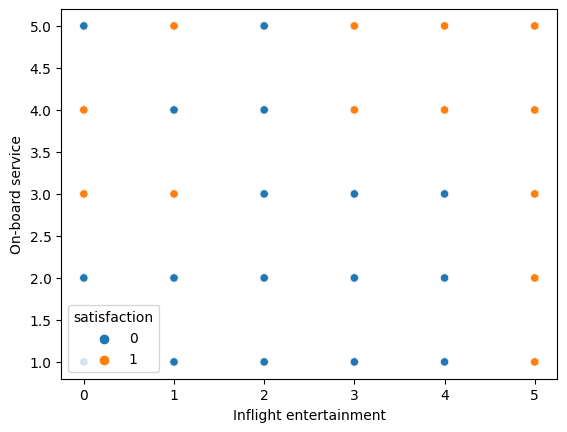

In [15]:
sns.scatterplot(x=data['Inflight entertainment'], y=data['On-board service'],hue=data['satisfaction'])

# **KNN**

In [16]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

knn_acc = metrics.accuracy_score(y_test, y_pred)
knn_precision = metrics.precision_score(y_test, y_pred)
knn_recall = metrics.recall_score(y_test, y_pred)
knn_f1 = metrics.f1_score(y_test, y_pred)

In [18]:
print('Accuracy: ', knn_acc)
print('Precision: ',knn_precision )
print('Recall: ', knn_recall)
print('F1: ', knn_f1)

Accuracy:  0.8998662654630558
Precision:  0.9342316329804299
Recall:  0.8808227465214761
F1:  0.9067413981005761


In [19]:
k_values = [i for i in range(1,31)]
scores=[]

scaler = StandardScaler()
X=scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score= cross_val_score(knn,X,y,cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

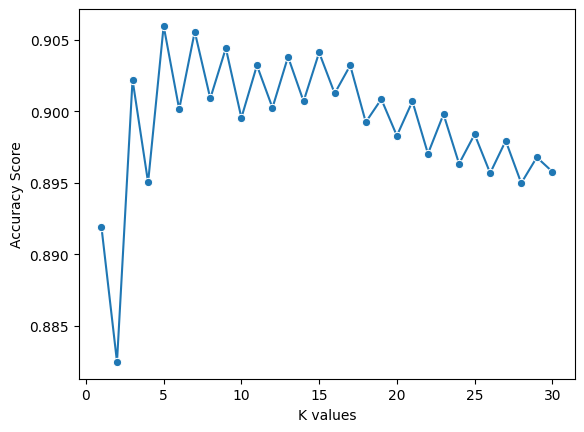

In [20]:
sns.lineplot(x = k_values, y = scores, marker='o')

plt.xlabel('K values')
plt.ylabel('Accuracy Score')

In [21]:
best_index = np.argmax(scores)
best_k = k_values[best_index]

print("Best K-Value: ", best_k, best_index)

Best K-Value:  5 4


In [22]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

knnbest_acc = metrics.accuracy_score(y_test, y_pred)
knnbest_precision = metrics.precision_score(y_test, y_pred)
knnbest_recall = metrics.recall_score(y_test, y_pred)
knnbest_f1 = metrics.f1_score(y_test, y_pred)

print('Accuracy: ', knnbest_acc)
print('Precision: ',knnbest_precision )
print('Recall: ', knnbest_recall)
print('F1: ', knnbest_f1)

Accuracy:  0.9008692744901371
Precision:  0.9394233884029802
Recall:  0.8771929824561403
F1:  0.907242296261536


In [23]:
data = [
    {'Model': "Decision Tree", 'F1': dt_f1, 'Recall': dt_rec, 'Precision': dt_prec, 'Accuracy': dt_acc},
    {'Model': "Random Forest", 'F1': randomforest_f1, 'Recall': randomforest_recall, 'Precision': randomforest_precision, 'Accuracy': randomforest_accuracy},
    {'Model': "Gradient Boosting", 'F1': gradient_f1, 'Recall': gradient_recall, 'Precision': gradient_precision, 'Accuracy': gradient_accuracy},
    {'Model': "XGBoost", 'F1': f1_score, 'Recall': rc_score, 'Precision': pc_score, 'Accuracy': ac_score},
    {'Model': "SVC", 'F1': svc_f1, 'Recall': svc_recall, 'Precision': svc_precision, 'Accuracy': svc_acc},
    {'Model': "KNN", 'F1': knn_f1, 'Recall': knn_recall, 'Precision': knn_precision, 'Accuracy': knn_acc},
    {'Model': "Best KNN", 'F1': knnbest_f1, 'Recall': knnbest_recall, 'Precision': knnbest_precision, 'Accuracy': knnbest_acc}
]

table = pd.DataFrame(data)

print(table)

               Model        F1    Recall  Precision  Accuracy
0      Decision Tree  0.922333  0.923170   0.921498  0.914076
1      Random Forest  0.947608  0.946461   0.948757  0.942160
2  Gradient Boosting  0.931291  0.928615   0.933982  0.924273
3            XGBoost  0.925102  0.924682   0.925522  0.917252
4                SVC  0.589485  0.520569   0.679432  0.599298
5                KNN  0.906741  0.880823   0.934232  0.899866
6           Best KNN  0.907242  0.877193   0.939423  0.900869
